#  INIT

In [1]:
import sys
sys.path.append('../../')
sys.path.append('../infras/cellMix/')
sys.path.append('../infras/dashboards/')
sys.path.append('../infras/cytof_data/')
sys.path.append('../experiments/')
sys.path.append('../preprocess/cell_specifics/')

In [2]:
from cellMix_coordinator import CellMixCoordinator
from cytof_cell_count_infra import CytofCellCountInfra
from cell_proportions_experiments import  CellProportionsExperiments
from pp_clean_irrelevant_proteins import PpCleanIrrelevantProteins

ccc= CytofCellCountInfra()

In [3]:
import exploration_plots
import dashs

In [4]:
import pandas as pd
import numpy as np
from functools import partial
import multiprocessing

from scipy.optimize import least_squares
from sklearn.metrics import mean_squared_error
from functools import partial
from scipy.optimize import minimize
import scipy.optimize
import scipy.stats
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

import os

import random

In [5]:
from deconv_py.preprocess.base import BasePreprocess as PP_base
from deconv_py.preprocess.cell_specific import CellSpecific as PP_proteins

from deconv_py.infras.data_factory import DataFactory
from deconv_py.infras.data_loader import DataLoader

from deconv_py.models.base import Base as Models_base
from deconv_py.models.cell_proportions_models import CellProportions
from deconv_py.models.cell_specific_models import CellSpecificPerPermutation

from deconv_py.experiments.cell_specific import CellSpecificMetricsPlot

from scipy.stats import entropy
from functools import reduce

# from deconv_py.infras.cellMix.cellMix_coordinator import CellMixCoordinator

In [6]:
data_loader = DataLoader(mass_spec_path=os.path.abspath('../data/20190801_filtered_imputed_data.csv'),
                         protein_profile_path = os.path.abspath('../data/20150718_Cerberus_proteinGroups.txt'),as_csv = True)
data_factory = DataFactory(data_loader)
ms = data_loader.get_mass_spec_data()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2963: DtypeWarning: Columns (5,6,2764,2765,2773,2774,2775,2776) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
def pick_random_value_from_intra_range(profile):
    if os.path.exists("cache/random_value_from_intra_range_df.pkl") :
        random_value_from_intra_range_df = pd.read_pickle("cache/random_value_from_intra_range_df.pkl") 
        return random_value_from_intra_range_df
            
    gene_to_profile_data = profile.copy(deep=True).T
    gene_to_profile_data["cell"]=gene_to_profile_data.index.map(lambda x:x.split('_0')[0])

    min_gene_to_profile_data = gene_to_profile_data.groupby("cell").min().T
    max_gene_to_profile_data = gene_to_profile_data.groupby("cell").max().T

    random_profile = pd.DataFrame(index=min_gene_to_profile_data.index,columns = min_gene_to_profile_data.columns)
    for index, cell_data in min_gene_to_profile_data.iterrows(): 
        for cell in cell_data.index :
            min_val = min_gene_to_profile_data.loc[index,cell]
            max_val = max_gene_to_profile_data.loc[index,cell]

            if max_val == 0 :
                continue

            random_profile.loc[index,cell] = random.randrange(min_val,max_val)
    random_profile = random_profile.fillna(0)
    random_profile.to_pickle("cache/random_value_from_intra_range_df.pkl")
    return random_profile

In [8]:
relvent_data_intensity = data_factory._build_relvent_data( DataFactory.IBD_A_RELVENT_DATA_all_vs,"Intensity")
profile_data_intensity,profile_data_relvent_data_intensity = data_factory.build_cell_specific_profile(auto_filter_by=False,relvent_data=relvent_data_intensity,relvent_columns=["Majority protein IDs","Gene names"])
mixtures,mixtures_relvent_data = data_factory.build_mixture_data(relvent_data= ms.columns.tolist() ,relvent_columns=["Majority protein IDs","Gene.names"],auto_filter_by=False,log2_transformation=True)

In [9]:
protein_gene_map = profile_data_intensity[["Majority protein IDs","Gene names"]].set_index("Majority protein IDs").to_dict()['Gene names']

# explore noise distribution

## mean vs var

In [10]:
ppclean = PpCleanIrrelevantProteins()
A_all_vs,_ = data_factory.load_IBD_all_vs("Intensity",index_func=lambda x:x,log2_transformation=True)
A_all_vs,_ = ppclean.transform([A_all_vs,_])

C:\ProgramData\Anaconda3\lib\site-packages\IPython\kernel\__main__.py:2: DtypeWarning: Columns (5,6,2764,2765,2773,2774,2775,2776) have mixed types. Specify dtype option on import or set low_memory=False.
  from ipykernel import kernelapp as app


In [11]:
full_profile_data = A_all_vs.copy(deep=True).T
full_profile_data["cell_for_gb"] = full_profile_data .index.map(lambda x: x.split('_0')[0])

full_profile_data_var = full_profile_data.groupby("cell_for_gb").std()#/full_profile_data.groupby("cell_for_gb").mean()
full_profile_data_mean = full_profile_data.groupby("cell_for_gb").mean()

C:\Users\Shenorr\AppData\Roaming\Python\Python36\site-packages\pandas\core\generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


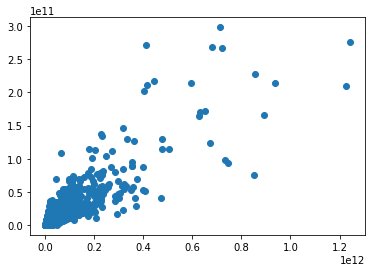

In [12]:
var =  full_profile_data_var.reset_index().melt(["cell_for_gb"]).set_index(['cell_for_gb', 'Gene names', 'major_protein_id'])
mean = full_profile_data_mean.reset_index().melt(["cell_for_gb"]).set_index(['cell_for_gb', 'Gene names', 'major_protein_id'])


mean_var = mean.merge(var,left_index=True,right_index=True,suffixes=(["_mean","_var"]))
mean_var = mean_var.sort_values(by="value_mean")
# plt.scatter(np.log(mean_var["value_mean"]),np.log(mean_var["value_var"]))
plt.scatter((mean_var["value_mean"]),(mean_var["value_var"]))


# build data

## A_intensity,B,random_profile,A_all_vs,B_all_vs

In [ ]:
index_func = lambda x:x
_profile_data_intensity,_mixtures = PP_base.return_mutual_proteins_by_index(profile_data_intensity,mixtures,index_func=index_func)
A_all_vs = _profile_data_intensity[profile_data_relvent_data_intensity].copy(deep=True)
B_all_vs = _mixtures[mixtures_relvent_data].copy(deep=True)

In [ ]:
A_intensity = A_all_vs.copy(deep=True)[[col for col in A_all_vs.columns if "01" in col]]
B = B_all_vs[[col for col in B_all_vs.columns if "v1" in col]]

A_intensity,B = PP_proteins.pp_clean_irrelevant_proteins(A_intensity,B)
A_all_vs = A_all_vs.merge(_profile_data_intensity["Gene names"].to_frame(),left_index=True,right_index=True).set_index(["Gene names"],append=True)

A = A_intensity.rename({f:f.split('Intensity NOT_')[1] for f in A_intensity.columns},axis=1)

simulated_profile = pick_random_value_from_intra_range(A_all_vs.copy())
simulated_profile = simulated_profile.rename({f:f.split('Intensity NOT_')[1] for f in simulated_profile.columns},axis=1)

## simulated_mixtures,simulated_X

### simulated_X

In [ ]:
cell_ref_freq = pd.read_csv('../data/cell_references_frequency.csv')
cell_to_freq_map = cell_ref_freq[["mass_name","range_srt"]].set_index("mass_name").to_dict()["range_srt"]

def my_distribution(min_val, max_val, mean, std):
    scale = max_val - min_val
    location = min_val
    # Mean and standard deviation of the unscaled beta distribution
    unscaled_mean = (mean - min_val) / scale
    unscaled_var = (std / scale) ** 2
    # Computation of alpha and beta can be derived from mean and variance formulas
    t = unscaled_mean / (1 - unscaled_mean)
    beta = ((t / unscaled_var) - (t * t) - (2 * t) - 1) / ((t * t * t) + (3 * t * t) + (3 * t) + 1)
    alpha = beta * t
    # Not all parameters may produce a valid distribution
    if alpha <= 0 or beta <= 0:
        raise ValueError('Cannot create distribution for the given parameters.')
    # Make scaled beta distribution with computed parameters
    return scipy.stats.beta(alpha, beta, scale=scale, loc=location)

def build_random_proportions(A,cell_to_freq_map,number_of_mixtures = 50):    
    all_cells = A.columns.tolist()
    cells_dist_params = {}
    for cell,params in cell_to_freq_map.items():
        params_list = [float(params.split("min:")[1][:4]),float(params.split("avg:")[1][:4]),float(params.split("max:")[1][:4])]
        cells_dist_params[cell] = params_list
        all_cells.remove(cell)

    noise_ratio = np.round(30/len(all_cells),2)
    for cell in all_cells:
        cells_dist_params[cell] = [0,noise_ratio,2*noise_ratio]

    X = pd.DataFrame(columns=range(number_of_mixtures))
    for cell,params in cells_dist_params.items():
        dist=my_distribution(params[0],params[2],params[1],params[1]/4)
        cell_name = cell.split("_0")[0]
        X.loc[cell_name] = dist.rvs(number_of_mixtures)
    return X/X.sum()

simulated_X = build_random_proportions(A,cell_to_freq_map)

### simulated_mixtures

In [ ]:
def is_zero_noise(chance,percantage_to_zero = 0.1):
    if np.random.random() < chance :
        return np.random.random() < percantage_to_zero
    return False
        
#add zeros :

quantile_normalization_salt_noise = 0.8
percantage_to_zero = 0.1
chance_to_be_zero = 1- simulated_mixtures/simulated_mixtures.quantile(quantile_normalization_salt_noise).mean()
noise_location = chance_to_be_zero.applymap(lambda x:is_zero_noise(x,percantage_to_zero))
simulated_mixtures[noise_location] = 0

# models results

In [ ]:
cell_prop_exp = CellProportionsExperiments()

In [ ]:
_A, _B = PP_proteins.pp_clean_irrelevant_proteins(simulated_profile.copy(deep=True), simulated_mixtures.reset_index("Gene names",drop=True).copy(deep=True))
_A_norm = _A.div(_A.sum(axis=1), axis=0)
gene_entropy = _A_norm.apply(lambda gene_dis: entropy(gene_dis), axis=1)

gene_entropy_trh = 0.001

In [ ]:
cell_to_list_of_max_genes = {}
for protein,cell in  _A.idxmax(axis=1).to_dict().items() : 
    if cell in cell_to_list_of_max_genes.keys():
        cell_to_list_of_max_genes[cell].append(protein)
    else : 
        cell_to_list_of_max_genes[cell] = [] 

list_of_genes_list = []

for cell in _A.columns:
    n_genes_per_cell = 20
    cell_relvent_gene_entropy = gene_entropy[_A_norm[_A_norm[cell] > 0].index]
#     cell_relvent_gene_entropy = cell_relvent_gene_entropy.loc[cell_to_list_of_max_genes[cell]].dropna()
    #takse genes with zero entropy and the largest values
    zero_entropy_genes = _A[cell].loc[cell_relvent_gene_entropy[cell_relvent_gene_entropy == 0].index]
    best_zero_entropy_genes = zero_entropy_genes.nlargest(n_genes_per_cell).index
    
    best_genes_idx = best_zero_entropy_genes
    #how much genes we still need - 
    n_genes_per_cell = n_genes_per_cell - best_zero_entropy_genes.shape[0]
    trh = gene_entropy_trh
    while best_genes_idx.shape[0] <  n_genes_per_cell  :
        low_quantile_entropy_genes = _A[cell].loc[cell_relvent_gene_entropy[(cell_relvent_gene_entropy < cell_relvent_gene_entropy.quantile(trh)) & (cell_relvent_gene_entropy >0)].index]
        best_quantile_entropy_genes = low_quantile_entropy_genes.nlargest(n_genes_per_cell).index
        best_genes_idx = best_genes_idx.union(best_quantile_entropy_genes)
        trh=trh+gene_entropy_trh
        if trh > 1 :
            print(cell)
            break

    list_of_genes_list.append(best_genes_idx)
     
    list_of_genes_list.append(best_genes_idx)

genes_list_idx = reduce(lambda x, y: x.union(y), list_of_genes_list)

filt_A = _A.copy(deep=True).loc[genes_list_idx]
filt_B = _B.copy(deep=True).loc[genes_list_idx]

norm_filt_A = filt_A.div(filt_A.max(axis=1), axis=0)
norm_filt_B = filt_B.div(filt_A.max(axis=1), axis=0)



In [ ]:
cmc = CellMixCoordinator()
def calc_with_cellmix(_a,_b,X,with_cellMix = False,as_heatmap = False) : 
    if _a.empty :
        raise Exception("A is empty")
    if _b.empty :
        raise Exception("B is empty")
    
    cell_abundance_over_samples = CellProportions.fit_as_df(_a,_b)
    cellMax_cell_abundance_over_samples = cmc.cell_prop_with_bash(_b,_a).rename({"Unnamed: 0":"cells"},axis=1).set_index("cells")
    
    return cell_abundance_over_samples,cellMax_cell_abundance_over_samples
    

In [ ]:
cell_abundance_over_samples,cellMax_cell_abundance_over_samples = calc_with_cellmix(filt_A,filt_B,simulated_X,True)

In [ ]:
for cell_namse,prop in cellMax_cell_abundance_over_samples.iterrows() :
    cell  = cell_namse.split("_0")[0]
    x_prop = simulated_X.loc[cell]
    plt.scatter(prop,x_prop)
    plt.title(cell)
    plt.show()

In [ ]:
filt_B